In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import johnsonsu
from sklearn.metrics import mean_squared_error
from arch import arch_model
from scipy.stats import mode
from scipy.stats import norm, skewnorm, kurtosis, skew

In [41]:
files_path = r"C:\Users\Asus\Documents\Coding\SET code\SET 50 Historical Data (3).csv"
data = pd.read_csv(files_path)
data

,Date,Price,RET
0,5/6/2025,772.84,-0.005227
1,5/2/2025,776.89,0.001417
2,04/30/2025,775.79,0.028489
3,04/29/2025,754.00,0.014387
4,04/28/2025,743.23,0.002303
...,...,...,...
1534,1/8/2019,1067.20,0.000197
1535,1/7/2019,1066.99,0.011974
1536,1/4/2019,1054.29,0.012215
1537,1/3/2019,1041.49,-0.005000


In [49]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date').reset_index(drop=True)

In [47]:
data

,Date,Price
1,2019-01-03,1041.49
2,2019-01-04,1054.29
3,2019-01-07,1066.99
4,2019-01-08,1067.20
5,2019-01-09,1064.82
...,...,...
1534,2025-04-28,743.23
1535,2025-04-29,754.00
1536,2025-04-30,775.79
1537,2025-05-02,776.89


In [55]:
prices = data['Price']
returns = prices.pct_change().dropna()
returns.describe()

count    1537.000000
mean       -0.000129
std         0.011393
min        -0.116964
25%        -0.005213
50%        -0.000031
75%         0.005046
max         0.092660
Name: Price, dtype: float64

In [141]:
threshold = 0.03

def state(r):
    if r >  threshold: return 'up'
    if r < -threshold: return 'down'
    return 'stationary'

states = returns.map(state)
print(threshold)


0.03


In [143]:
# 3. Build (and smooth) the 3×3 transition matrix
alpha = 1  # pseudocount for smoothing
counts = pd.crosstab(states, states.shift(-1))
bayes = counts + alpha
P = bayes.div(bayes.sum(axis=1), axis=0)

print("Transition matrix:\n", P)



Transition matrix:
 Price           down  stationary        up
Price                                     
down        0.117647    0.705882  0.176471
stationary  0.007947    0.982781  0.009272
up          0.166667    0.777778  0.055556


In [145]:
# 4. Predict tomorrow’s distribution
today = states.iloc[-1]
probs = P.loc[today]
print(f"\nIf today is “{today}” → P(tomorrow):\n", probs)




If today is “stationary” → P(tomorrow):
 Price
down          0.007947
stationary    0.982781
up            0.009272
Name: stationary, dtype: float64


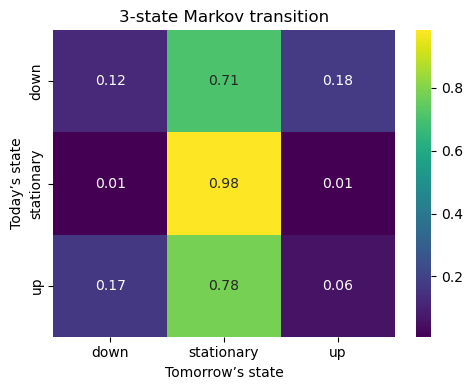


Simulated next 10 states: ['stationary', 'stationary', 'stationary', 'stationary', 'stationary', 'stationary', 'stationary', 'stationary', 'stationary', 'stationary', 'stationary']


In [147]:
# 5. (Optional) draw it
plt.figure(figsize=(5,4))
sns.heatmap(P, annot=True, fmt=".2f", cmap='viridis')
plt.title("3-state Markov transition")
plt.ylabel("Today’s state")
plt.xlabel("Tomorrow’s state")
plt.tight_layout()
plt.show()


# 6. Simulate a single path of length N:
def simulate(P, start, N=10):
    s = start
    path = [s]
    for _ in range(N):
        s = np.random.choice(P.columns, p=P.loc[s])
        path.append(s)
    return path

print("\nSimulated next 10 states:", simulate(P, today, N=10))

In [348]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Bidirectional
import pandas_ta as ta
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [404]:
data['rsi14']     = ta.rsi(data['Price'], length=14)
data['ma20']      = data['Price'].rolling(20).mean()
data['vol10']     = data['Price'].pct_change().rolling(10).std()
data['mom5']      = data['Price'].diff(5)

In [406]:
returns = data['Price'].pct_change().dropna().values
threshold = 0.001
labels = np.where(returns>threshold, 2, np.where(returns< threshold, 0, 1))

# Build windows of length window using all engineered features
#window = 20  # try 20 instead of 10
# X will be shape (n_samples, window, n_features)
# Y will be one-hot(labels)
window, n_features = X_train.shape[1], X_train.shape[2]

In [408]:
# Compute class weights on Y_train
y_int = np.argmax(Y_train, axis=1)
classes = np.unique(y_int)
weights = compute_class_weight('balanced', classes=classes, y=y_int)
class_weight = dict(zip(classes, weights))

lstm_model = Sequential([
    Input(shape=(window, n_features)),
    LSTM(64, return_sequences=True, recurrent_dropout=0.2),
    LSTM(32, recurrent_dropout=0.2),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])
lstm_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

# **Now** this fit supports validation_data and class_weight:
history = lstm_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=16,
    class_weight=class_weight,
    callbacks=[es, rlr]
)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.3773 - loss: 1.0721 - val_accuracy: 0.2614 - val_loss: 1.0926 - learning_rate: 0.0010
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3216 - loss: 1.0984 - val_accuracy: 0.3333 - val_loss: 1.0762 - learning_rate: 0.0010
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2897 - loss: 1.1046 - val_accuracy: 0.3072 - val_loss: 1.0809 - learning_rate: 0.0010
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3620 - loss: 1.0583 - val_accuracy: 0.2549 - val_loss: 1.1038 - learning_rate: 0.0010
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3437 - loss: 1.0792 - val_accuracy: 0.2941 - val_loss: 1.0990 - learning_rate: 0.0010
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3495 - loss: 1.0550 - val_accuracy: 0.2418 - val_loss: 1.1227 - learning_rate: 5.0000e-04
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3107 - loss: 1.0748 - val_accur

In [201]:
'''# 3. Prepare sequences for LSTM
window = 10
X, Y = [], []
for i in range(len(returns) - window):
    X.append(returns[i:i+window])
    Y.append(labels[i+window])
X = np.array(X)
Y = np.array(Y)

In [203]:
# 4. Scale features
'''scaler = StandardScaler()
nsamples, nsteps = X.shape
X_scaled = scaler.fit_transform(X.reshape(-1, 1)).reshape(nsamples, nsteps, 1)'''

In [205]:
#Y_onehot = tf.keras.utils.to_categorical(Y, num_classes=3)

In [207]:
'''X_train, X_val, Y_train, Y_val = train_test_split(
    X_scaled, Y_onehot, test_size=0.2, shuffle=False)'''

In [410]:
model = Sequential([
    Input(shape=(window, n_features)),
    Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2)),
    Bidirectional(LSTM(32, recurrent_dropout=0.2)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(3, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [412]:
es  = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50, batch_size=16,
    callbacks=[es, rlr],
    class_weight=class_weight  # handle imbalance
)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.3276 - loss: 1.1062 - val_accuracy: 0.3595 - val_loss: 1.0773 - learning_rate: 0.0010
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3940 - loss: 1.0965 - val_accuracy: 0.2908 - val_loss: 1.1029 - learning_rate: 0.0010
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3327 - loss: 1.0935 - val_accuracy: 0.3105 - val_loss: 1.0984 - learning_rate: 0.0010
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3223 - loss: 1.0911 - val_accuracy: 0.3791 - val_loss: 1.0644 - learning_rate: 0.0010
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3761 - loss: 1.0874 - val_accuracy: 0.2614 - val_loss: 1.1131 - learning_rate: 0.0010
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3735 - loss: 1.0788 - val_accuracy: 0.2320 - val_loss: 1.1560 - learning_rate: 0.0010
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3143 - loss: 1.0869 - val_ac

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3361 - loss: 1.0888 
Val accuracy: 0.379084974527359


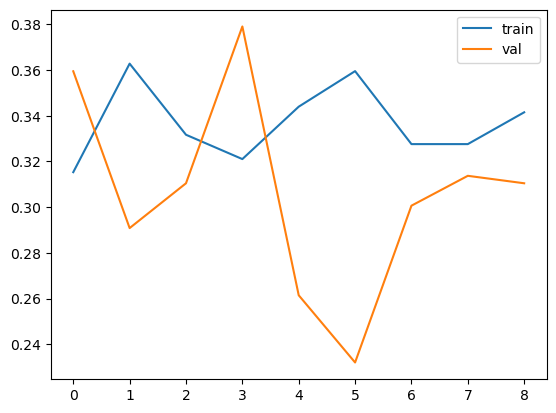

In [417]:
# Plot train vs val accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()

# Final validation accuracy
loss, acc = model.evaluate(X_val, Y_val)
print("Val accuracy:", acc)


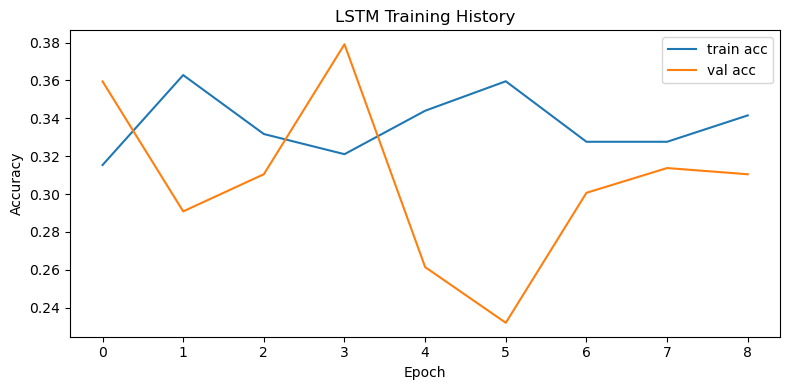


Validation accuracy: 0.379
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Predicted probabilities for tomorrow:
  down: 0.335
  stationary: 0.354
  up: 0.311


In [419]:
# 9. Plot history
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('LSTM Training History'); plt.legend()
plt.tight_layout(); plt.show()

    # 10. Evaluate & predict
loss, acc = model.evaluate(X_val, Y_val, verbose=0)
print(f"\nValidation accuracy: {acc:.3f}")
last_win = returns[-window:].reshape(1, window, 1)
next_probs = model.predict(last_win).flatten()
mapping = {0: 'down', 1: 'stationary', 2: 'up'}
print("\nPredicted probabilities for tomorrow:")
for i, p in enumerate(next_probs):
    print(f"  {mapping[i]}: {p:.3f}")

In [421]:
import os
os.environ['OMP_NUM_THREADS'] = '7'   # or any number ≤ your core count
from hmmlearn.hmm import GaussianHMM

In [423]:
returns = prices.pct_change().dropna().values.reshape(-1, 1)

In [425]:
model = GaussianHMM(
    n_components=3,
    covariance_type='diag',
    n_iter=100,
    init_params='stc'   # drop 'm' so no means re-init via KMeans
)
model.means_ = np.array([[-0.01], [0.0], [0.01]])  # example manual init
model.fit(returns)
model.fit(returns)

Model is not converging.  Current: 5061.947640594523 is not greater than 5062.532575760706. Delta is -0.5849351661827313
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5065.988001964489 is not greater than 5066.003316875879. Delta is -0.015314911390305497


GaussianHMM(init_params='stc', n_components=3, n_iter=100)

In [427]:
hidden_states = model.predict(returns)

In [429]:
state_means = model.means_.flatten()
order = np.argsort(state_means)
direction_map = {
    order[0]: 'down', 
    order[1]: 'stationary', 
    order[2]: 'up'
}

In [431]:
last_state = hidden_states[-1]
trans_probs = model.transmat_[last_state]
pred_probs = {direction_map[i]: float(f"{trans_probs[i]:.3f}") for i in range(3)}

# 7. Display results
print("HMM state means:", np.round(state_means, 5))
print("Transition matrix:\n", np.round(model.transmat_, 3))
print(f"\nLast hidden state: {last_state} → labeled '{direction_map[last_state]}'")
print("Predicted direction probabilities for tomorrow:", pred_probs)

HMM state means: [-0.01238  0.00231 -0.00016]
Transition matrix:
 [[0.933 0.067 0.   ]
 [0.01  0.861 0.128]
 [0.    0.01  0.99 ]]

Last hidden state: 2 → labeled 'stationary'
Predicted direction probabilities for tomorrow: {'down': 0.0, 'up': 0.01, 'stationary': 0.99}


In [25]:
df = pd.read_excel(r"C:\Users\Asus\Documents\Coding\SET code\SET50_scenerio(1).xlsx", index_col=0)
df_T = df.T  # ตอนนี้ rows = วัน, columns = scenarios

In [37]:
df.describe()

,Day_1_pred_price,Day_2_pred_price,Day_3_pred_price,Day_4_pred_price,Day_5_pred_price,Day_6_pred_price,Day_7_pred_price,Day_8_pred_price,Day_9_pred_price,Day_10_pred_price,...,Day_21_pred_price,Day_22_pred_price,Day_23_pred_price,Day_24_pred_price,Day_25_pred_price,Day_26_pred_price,Day_27_pred_price,Day_28_pred_price,Day_29_pred_price,Day_30_pred_price
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,883.219496,883.230133,883.421782,882.634105,883.535635,884.054467,883.514410,882.243365,882.639815,882.603053,...,883.442721,882.785002,883.255869,882.568672,882.252115,882.686632,883.427528,884.140875,884.071346,883.401839
std,6.443937,9.760450,11.208792,13.281763,15.538433,17.485970,18.864729,20.667121,22.773692,23.999036,...,32.348846,33.351443,34.392967,32.961151,33.650203,33.983368,35.490719,36.453898,37.561645,38.720803
min,870.616625,857.793939,842.464393,837.186694,847.563963,839.106544,837.439002,839.148844,833.028777,828.589311,...,805.621925,802.060375,803.490861,807.701749,799.132422,806.907315,803.245411,802.215258,788.836246,779.136688
25%,878.384817,876.133248,874.955033,872.945257,874.287949,870.844165,868.999021,867.075458,866.226612,865.175420,...,860.311480,857.024670,860.007441,858.281297,859.724558,857.766214,860.329472,860.293652,855.062307,857.283821
50%,882.878876,884.246071,882.449885,883.039241,883.173781,884.455514,883.302566,880.292047,881.961145,879.973349,...,886.012910,884.137907,881.455472,881.317432,880.803322,880.296431,882.552186,882.703802,882.480680,881.173790
75%,887.901944,890.431736,890.650319,892.428297,893.786245,896.153238,897.287532,895.774543,897.775729,898.234184,...,905.899785,908.094998,908.421764,908.079682,906.108901,906.450175,906.230290,907.853798,911.686482,910.748447
max,899.231415,903.645933,911.161962,909.996259,919.513063,926.625121,930.097398,944.809923,935.210187,947.335684,...,953.148016,956.866912,960.533038,955.300826,961.911476,971.374938,974.043204,985.796349,971.981489,978.535949


In [33]:
strike_levels = [-200, -100, -50, 0, 50, 100]

for level in strike_levels:
    df_T[f'Strike_{level:+}'] = df_T.apply(lambda row: ((row - level) // 25 * 25).astype(int), axis=1)

ValueError: Cannot set a DataFrame with multiple columns to the single column Strike_-200